# Bayesian analysis of tests with unknown specificity and sensitivity

**Authors:** Andrew Gelman and Bob Carpenter 

Reparametrization: https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html

Data types: https://mc-stan.org/docs/2_19/reference-manual/univariate-data-types-and-variable-declarations.html

We redo the work developed in the article as exercise using `pystan`. 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import expit

import pymc3 as pm
import pystan as ps

import pickle

ro = np.random.RandomState(1000)

Prevalence estimates (proportion of some characteristic in a population) is sensible to uncertainty in specificicity and sensitivity of the test. Hierarchical modelling is used with bayesian inference to model it in three different models. 

## Model 1

$$y \sim Bin(n,p),$$
$$p = (1 - \gamma)(1 - \pi) + \delta \pi,$$
$$y_{\gamma} \sim Bin(n_{\gamma}, \gamma),$$
$$y_{\delta} \sim Bin(n_{\delta}, \delta),$$

In [40]:
compiled = True

In [41]:
if compiled: 
    sm = pickle.load(open('pickles/model1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/model1.stan')
    with open('pickles/model1.pkl', 'wb') as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344 NOW.


## Data

First we simulate the data based on the first model.

In [42]:
n_sample = 100 
n_spec   = 20
n_sens   = 20

spec = 0.9 
sens = 0.9
pi   = 0.01
p    = (1 - spec)*(1 - pi) + sens*pi

y = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [43]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   1,
      "beta_pi":    1,
})

In [44]:
fit = sm.sampling(data=tests_data, iter=2000, chains=2)

In [45]:
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
spec         0.94  7.5e-4   0.03   0.89   0.93   0.94   0.96   0.98   1129    1.0
sens          0.9  1.8e-3   0.06   0.75   0.87   0.91   0.95   0.99   1284    1.0
pi           0.03  7.6e-4   0.03 9.7e-4   0.01   0.03   0.05    0.1   1265    1.0
p            0.09  5.9e-4   0.03   0.04   0.07   0.08    0.1   0.14   1985    1.0
spec_prior    0.5  6.6e-3   0.28   0.02   0.26   0.51   0.74   0.97   1837    1.0
sens_prior    0.5  6.7e-3   0.29   0.03   0.26    0.5   0.76   0.98   1861    1.0
pi_prior      0.5  6.7e-3   0.29   0.03   0.24   0.49   0.77   0.97   1899    1.0
p_prior       0.5  5.8e-3   0.23   0.07   0.32    0.5   0.69   0.93   1653    1.0
lp__       -44.63    0.05   1.33 -48.07 -45.23 -44.29 -43.65 -43.11    66

### Posterior checking

Plotting the posterior distributions and scatter plots. 

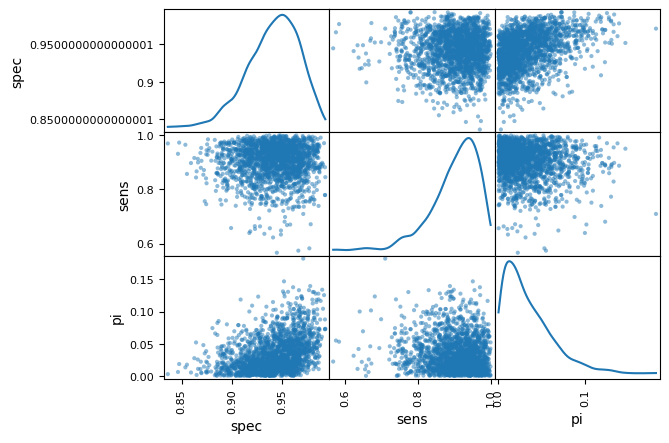

In [46]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

### Prior checking 

Below we see the iinduced prior distribution on $p$. Despite setting flat priors for all parameters, we observe a non plat prior on $p$. 

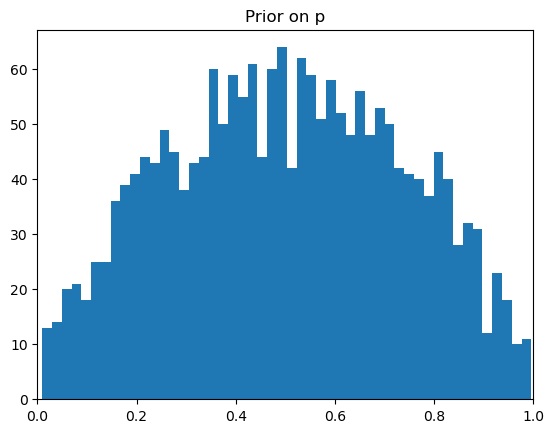

In [48]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

## Other hyperpriors

We test some other values. 

In [54]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=2, control=dict(adapt_delta=0.96))
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

             mean se_mean     sd     2.5%     25%     50%     75%  97.5%  n_eff   Rhat
spec         0.93  3.5e-4   0.02     0.87    0.91    0.93    0.94   0.97   4758    1.0
sens         0.91  8.5e-4   0.06     0.76    0.88    0.92    0.95   0.99   5163    1.0
pi         1.7e-3  1.2e-4 7.4e-3  2.2e-16 1.3e-12  9.2e-9  2.9e-5   0.02   3990    1.0
p            0.07  3.2e-4   0.02     0.04    0.06    0.07    0.09   0.13   5335    1.0
spec_prior    0.5  2.9e-3   0.29     0.02    0.25    0.51    0.75   0.98   9861    1.0
sens_prior    0.5  2.9e-3   0.29     0.03    0.26     0.5    0.75   0.97   9831    1.0
pi_prior     0.05  2.0e-3    0.2 2.7e-154 6.8e-58 1.8e-28 3.1e-11   0.98  10098    1.0
p_prior       0.5  2.9e-3   0.29     0.03    0.25    0.49    0.75   0.97  10028    1.0
lp__       -40.14    0.02 

Changing the prior distribution on $\pi$ (reduced the mean by 10), the induced on $p$ is more uniform! 

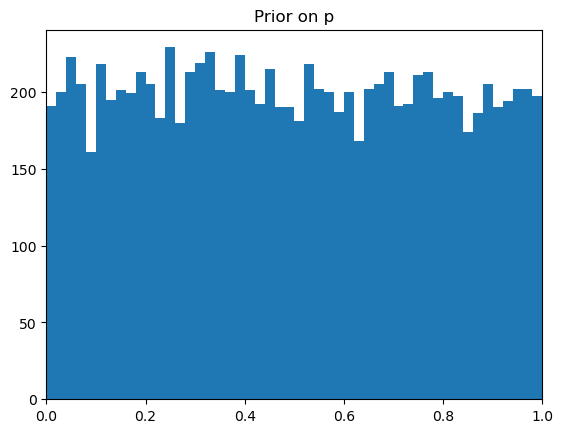

In [55]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

## Model 2

Now we adapt to a hierarchical model

$$
logit(\gamma_j) \sim normal(\mu_{\gamma}, \sigma_{\gamma}) \\
logit(\delta_j) \sim normal(\mu_{\delta}, \sigma_{\delta})
$$

where $j=1,...,J$ are studies for each parameter. 

**Remark:** The reparameterization of `logit_spec` and `logit_sens` with offset and multiplier, we obtain a non-central distribution wahat is computationally better. 

In [77]:
compiled = True

In [82]:
if compiled: 
    sm2 = pickle.load(open('pickles/model2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = 'stan_codes/model2.stan')
    with open('pickles/model2.pkl', 'wb') as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f03490079dc5cd0799978ea307a407af NOW.


## Data

First we simulate the data based on the second model.

In [83]:
n_sample = 100

J_spec   = 5
n_spec   = np.array([10,30,15,20,40])
J_sens   = 5
n_sens   = np.array([10,30,15,20,40])

mu_spec = np.array([2.5, 3.5, 2.2, 4.1, 3.2])
mu_sens = np.array([2.5, 3.5, 2.2, 4.1, 3.2])

sigma_spec = np.array([0.5, 0.2, 0.6, 0.1, 0.2])
sigma_sens = np.array([0.5, 0.2, 0.6, 0.1, 0.2])

spec = expit(ro.normal(loc = mu_spec, scale = sigma_spec))
sens = expit(ro.normal(loc = mu_spec, scale = sigma_spec))

pi   = 0.01
p    = (1 - spec[0])*(1 - pi) + sens[0]*pi

y      = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "J_spec": J_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "J_sens": J_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [84]:
tests_data.update({
      "alpha_pi"             : 0.1,
      "beta_pi"              : 1.9,  
      "mean_hyper_mean_spec" : 3,
      "mean_hyper_mean_sens" : 3, 
      "sd_hyper_mean_spec"   : 2,
      "sd_hyper_mean_sens"   : 2,
      "sd_hyper_sd_spec"     : 1,
      "sd_hyper_sd_sens"     : 1,
})

In [85]:
fit2 = sm2.sampling(data=tests_data, iter=3000, chains=4, control=dict(adapt_delta=0.95))

In [86]:
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                        mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi                      0.07  1.5e-3   0.05 1.0e-10   0.02   0.07   0.11   0.17   1170    1.0
mean_logit_spec          3.3    0.01   0.64    2.19   2.85   3.25    3.7   4.69   2433    1.0
mean_logit_sens         4.81    0.01   0.94    3.19   4.16   4.72   5.39   6.87   5477    1.0
sd_logit_spec           0.58  7.4e-3   0.45    0.02   0.23   0.48   0.82    1.7   3738    1.0
sd_logit_sens           0.67  7.2e-3   0.53    0.02   0.26   0.56   0.96    2.0   5437    1.0
logit_spec[1]            3.2    0.02   0.93    1.82   2.51    3.1   3.72   5.34   1552    1.0
logit_spec[2]           3.35  9.5e-3    0.7    2.18   2.87    3.3   3.77   4.91   5458    1.0
logit_spec[3]           3.19    0.01   0.73    1.88   2.71 

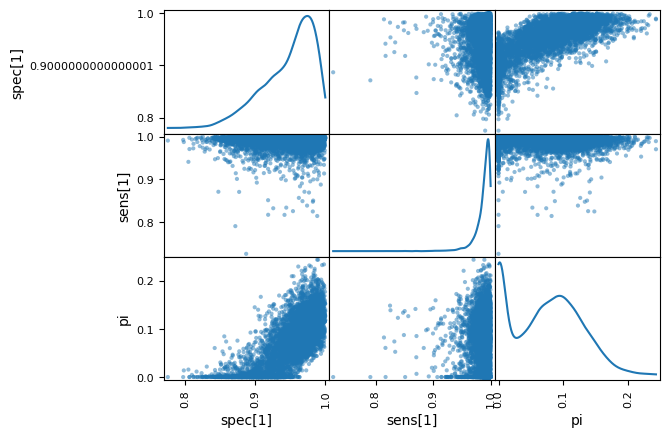

In [87]:
df_trace = pd.DataFrame(fit2.extract(['spec[1]', 'sens[1]', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

In [88]:
tests_data.update({
      "alpha_pi"             : 0.001,
      "beta_pi"              : 0.019,  
      "mean_hyper_mean_spec" : 0.5,
      "mean_hyper_mean_sens" : 0.5, 
      "sd_hyper_mean_spec"   : 0.5,
      "sd_hyper_mean_sens"   : 0.5,
      "sd_hyper_sd_spec"     : 0.5,
      "sd_hyper_sd_sens"     : 0.5,
})

fit2 = sm2.sampling(data=tests_data, iter=2000, chains=4, control=dict(adapt_delta=0.95, max_treedepth=12))
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%     25%      50%      75%  97.5%  n_eff   Rhat
pi                    6.2e-3  5.1e-4   0.02 2.2e-16 1.1e-12   9.3e-9   5.9e-5   0.08   1683    1.0
mean_logit_spec         1.92    0.01   0.37    1.03    1.72     1.97     2.18   2.55    968    1.0
mean_logit_sens         1.98    0.01   0.49    0.95    1.67     2.03     2.34   2.83   1390    1.0
sd_logit_spec           0.52    0.01   0.37    0.03    0.21     0.46     0.75   1.36   1040    1.0
sd_logit_sens           0.87    0.01   0.46    0.07    0.52     0.87     1.21   1.77   1308    1.0
logit_spec[1]           2.09  6.2e-3   0.33    1.56    1.89     2.07     2.25   2.77   2806    1.0
logit_spec[2]            2.4  8.9e-3    0.5    1.59    2.07     2.32     2.66    3.6   3221    1.0
logit_spec[3]      

## Considering bivariate beta distribution

Taking the bivariate form discussed in the notebook `bivariate_beta.ipynb`, we modified the first model a little. 

In [2]:
compiled = False

In [5]:
if compiled: 
    sm = pickle.load(open('pickles/model1_bivariate.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/model1_bivariate_wrong.stan')
    with open('pickles/model1_bivariate.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46a5b7cd86748b5dc4d941f7171c5fe4 NOW.


NameError: name 'model' is not defined

### Data

In [6]:
n_sample = 100 
n_spec   = 20
n_sens   = 20

spec = 0.9 
sens = 0.9
pi   = 0.01
p    = (1 - spec)*(1 - pi) + sens*pi

y = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

### Fitting the model

In [14]:
tests_data.update({
      "alpha": [10,1,1,1],
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=1, control=dict(adapt_delta=0.9))
print(fit)

Inference for Stan model: anon_model_46a5b7cd86748b5dc4d941f7171c5fe4.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

       mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
U[1]   0.79  2.1e-3   0.07    0.65    0.75    0.8   0.84    0.9    968    1.0
U[2]   0.11  2.2e-3   0.06  7.6e-3    0.06    0.1   0.15   0.25    866    1.0
U[3]   0.04  8.2e-4   0.03  8.2e-4    0.02   0.03   0.06   0.12   1545    1.0
U[4]   0.06  1.1e-3   0.04  4.4e-3    0.03   0.06   0.08   0.13    968    1.0
pi     0.01  1.9e-3   0.03 4.4e-16 3.8e-12 6.8e-8 7.2e-4   0.12    262    1.0
spec    0.9  1.5e-3   0.03    0.84    0.88    0.9   0.92   0.97    454    1.0
sens   0.83  1.8e-3   0.06     0.7    0.79   0.84   0.88   0.93   1112    1.0
p      0.11  4.1e-4   0.03    0.06    0.09   0.11   0.13   0.17   4538    1.0
lp__ -61.54    0.04   1.43  -65.14   -62.2 -61.16 -60.48 -59.85   1038    1.0

Samples were drawn using NUTS

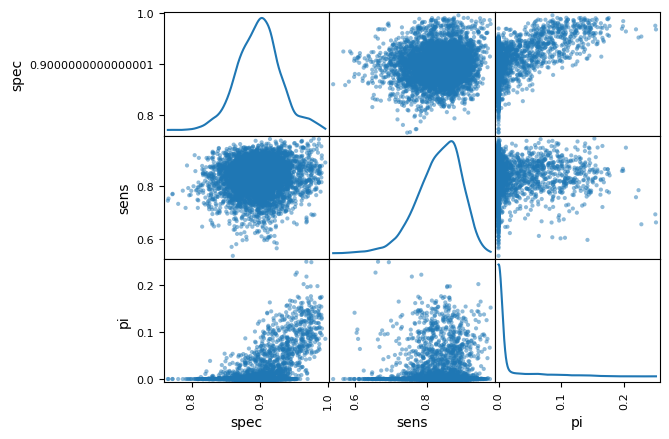

In [13]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()